In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [16]:
import copy

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorly as tl

In [3]:
import bokeh
import bokeh.plotting as bp

bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
%load_ext autoreload
%autoreload 2

import bnpm

In [15]:
tl.set_backend('pytorch')

Import face_rhythm TCA factors and spectrogram tensor

In [5]:
tca = bnpm.h5_handling.simple_load('/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/20230430/run_from_o2/analysis_files/TCA.h5')

In [6]:
params = bnpm.file_helpers.json_load('/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/20230430/run_from_o2/params.json')

In [78]:
DEVICE_data = bnpm.torch_helpers.set_device(use_GPU=False)

device: 'cpu'


make model

In [8]:
spec = bnpm.h5_handling.simple_load('/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/20230501/jobNum_0/analysis_files/VQT_Analyzer.h5')

In [9]:
run_info = bnpm.file_helpers.json_load('/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/20230501/jobNum_0/run_info.json')

In [10]:
s = spec['spectrograms']['0'].copy()
s = s.transpose(2,3,0,1)
s = s.reshape(s.shape[0], s.shape[1], -1)
s = s.transpose(2,0,1)
s = torch.as_tensor(s, dtype=torch.float32, device=DEVICE_data)

In [82]:
def cp_dict_to_cp_tensor(cp_dict, device='cpu'):
    return tl.cp_tensor.CPTensor((None, [torch.as_tensor(v, dtype=torch.float32, device=device) for v in cp_dict.values()]))

In [84]:
cp = cp_dict_to_cp_tensor(tca['factors_rearranged']['0'], device=DEVICE_data)

In [17]:
DEVICE_tca = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [87]:
def make_cp_init(k_tensor, shape_dense_tensor, modes_fixed=[0,1,], device='cpu'):
    import copy
    n_modes = len(k_tensor)
    kt = [None]*n_modes
    for i_mode in range(len(kt)):
        if i_mode in modes_fixed:
            kt[i_mode] = torch.as_tensor(k_tensor[i_mode], dtype=torch.float32, device=device)
        else:
            perm = torch.randperm(shape_dense_tensor[i_mode])
            kt[i_mode] = torch.as_tensor(k_tensor[i_mode], dtype=torch.float32, device=device)[perm]
        
    return tl.cp_tensor.CPTensor((None, kt))

In [88]:
cp_init = make_cp_init(cp.factors, s.shape, modes_fixed=[0,1,], device=DEVICE_tca)

In [66]:
params_tca = copy.deepcopy(params['TCA']['fit']['params_method'])

In [67]:
# params_tca['n_iter_max'] = 1000
params_tca['init'] = cp_init

In [68]:
model_tca = tl.decomposition.CP_NN_HALS(
    **params_tca,
    fixed_modes=[1,]
)

In [71]:
model_tca.fit(s.to(DEVICE_tca))

reconstruction error=0.5047152638435364
iteration 1, reconstruction error: 0.42256152629852295, decrease = 0.08215373754501343
iteration 2, reconstruction error: 0.41045066714286804, decrease = 0.012110859155654907
iteration 3, reconstruction error: 0.40655800700187683, decrease = 0.003892660140991211
iteration 4, reconstruction error: 0.40550917387008667, decrease = 0.0010488331317901611
iteration 5, reconstruction error: 0.40514853596687317, decrease = 0.000360637903213501
iteration 6, reconstruction error: 0.40498971939086914, decrease = 0.00015881657600402832
iteration 7, reconstruction error: 0.4049067199230194, decrease = 8.299946784973145e-05
iteration 8, reconstruction error: 0.40485531091690063, decrease = 5.1409006118774414e-05
iteration 9, reconstruction error: 0.4048183262348175, decrease = 3.698468208312988e-05
iteration 10, reconstruction error: 0.40478771924972534, decrease = 3.0606985092163086e-05
iteration 11, reconstruction error: 0.40475994348526, decrease = 2.777576

KeyboardInterrupt: 

In [76]:
tca['factors_rearranged']

{'0': {'(xy points)': array([[0.00093511, 0.00643426, 0.00660202, ..., 0.00632018, 0.00258544,
          0.00209764],
         [0.00097995, 0.00832128, 0.0107773 , ..., 0.00827198, 0.00423434,
          0.00277218],
         [0.00102555, 0.01167715, 0.01268135, ..., 0.01081985, 0.00579402,
          0.00396057],
         ...,
         [0.03056888, 0.03497452, 0.04063186, ..., 0.        , 0.00516783,
          0.00078287],
         [0.02209227, 0.04512347, 0.05235847, ..., 0.        , 0.00599351,
          0.00039529],
         [0.01930566, 0.05536688, 0.06403808, ..., 0.        , 0.00352175,
          0.00015068]], dtype=float32),
  'frequency': array([[1.97795369e-02, 2.33697653e-01, 1.72896609e-01, 4.68702585e-01,
          4.92070526e-01, 1.10264695e+00, 9.02988166e-02, 7.81257898e-02,
          2.30586791e+00, 1.43622565e+00, 5.35405874e-01, 0.00000000e+00],
         [2.82890312e-02, 1.92140222e-01, 1.73942551e-01, 4.26833659e-01,
          4.06636477e-01, 1.09679914e+00, 8.7479598

In [74]:
factors[1].shape

torch.Size([36, 12])

In [41]:
factors = model_tca.decomposition_.factors

In [42]:
factors[0].shape

torch.Size([1872, 12])

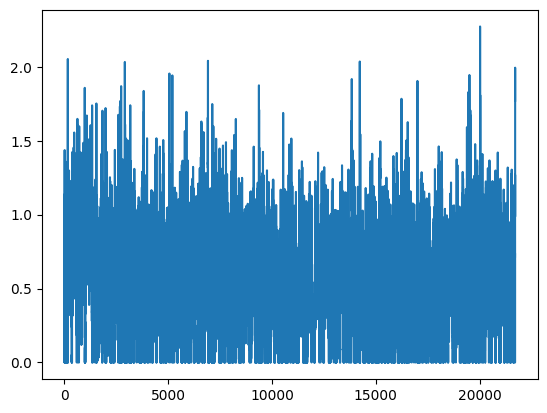

In [43]:
plt.figure()
plt.plot(factors[2][:,0].cpu())

In [70]:
bnpm.torch_helpers.clear_cuda_cache()